In [5]:
import numpy as np
import pandas as pd
import pickle
import torch

from util import is_json, parse_har, write_har, postprocess_har
from trace_gen import process_event, gen_trace
from feature_gen import gen_feature
from gen_types import Event, System
from plotter import plot_frequencies

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
base_path = "cs.uchicago.edu"

In [7]:
gen_trace = False

# ---------------------
num_worker = 1
num_user = 1
mission_hour = 1
# ---------------------

mission_minutes = mission_hour*60
mission_seconds = mission_hour*60*60

# ---------------------

if gen_trace:
    aggregate_har, sys = gen_trace(base_path, num_user, mission_minutes, num_worker)

In [8]:
# Load the HAR dict pickle file
gatech_har = pickle.load(open("user_200_hour_4_cs.uchicago.edu.har", "rb"))
gatech_processed = postprocess_har(gatech_har, base_path)
url_pdf = gatech_processed.groupby('url').size().sort_values(ascending=False)
url_pdf.head(40)

url
https://cs.uchicago.edu/                                                                                     748
https://howto.cs.uchicago.edu/lib/exe/js.php?t=dokuwiki&tseed=ec22f390edf26eae4ffeee9e97521674               599
https://howto.cs.uchicago.edu/lib/exe/jquery.php?tseed=f0349b609f9b91a485af8fd8ecd4aea4                      589
https://cs.uchicago.edu/wp-content/themes/csuc/build/fonts/GothamNarrSSm-Black_Web.woff2                     391
https://cs.uchicago.edu                                                                                      373
https://cs.uchicago.edu/wp-content/plugins/gravityforms/css/basic.min.css?ver=2.5.16                         339
https://cs.uchicago.edu/wp-content/uploads/2021/12/cropped-UChicagoShield_faviconArtboard-1-1-192x192.png    330
https://cs.uchicago.edu/wp-content/uploads/2021/11/UCCS-Color.svg                                            311
https://cs.uchicago.edu/wp-content/plugins/gravityforms/css/theme-ie11.min.css?ver=2.5.16   

In [9]:
urls = url_pdf.reset_index()['url'].tolist()

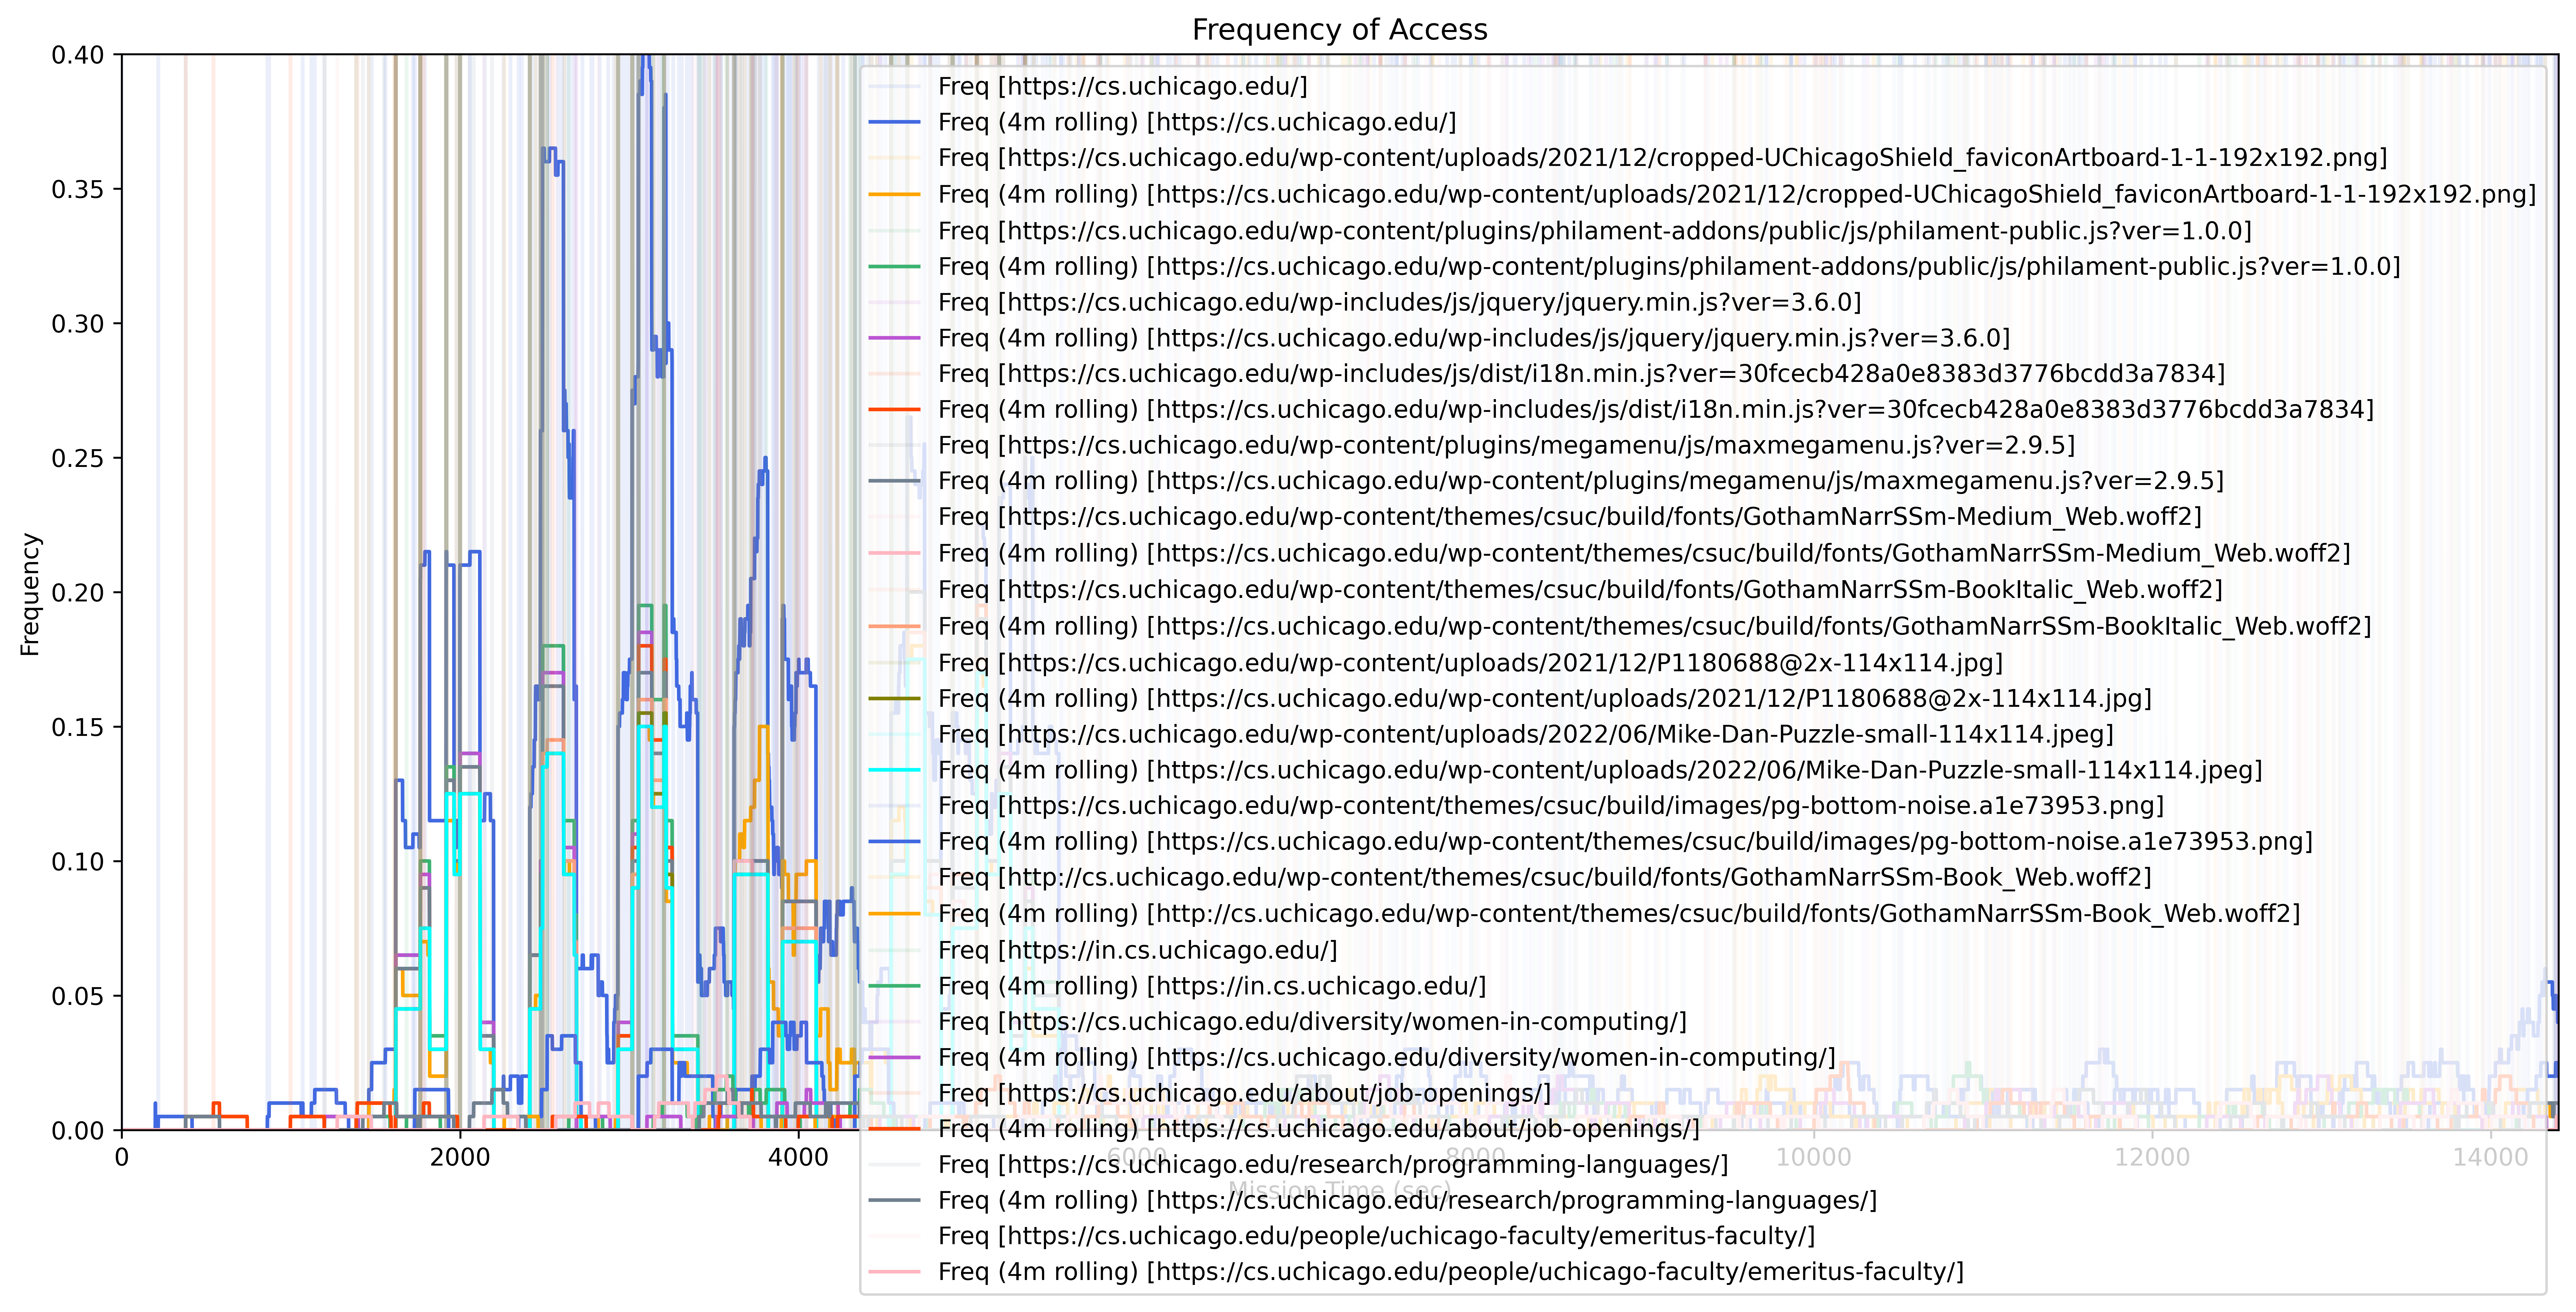

In [40]:
plot_urls = urls[0:100:6]
xclip=(0,4*3600)

frequency_pdfs = plot_frequencies(
    gatech_processed,
    plot_urls,
    4*60*60,
    200,
    (0,4*3600),
    (0,0.40)
)

In [174]:
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def gen_train(freq_pdf, seq_length, output_size):
    series = freq_pdf['count_rolling'].to_numpy()
    xs, ys = [], []
    for i in range(len(series) - seq_length - output_size - 1):
        xs.append(series[i:(i+seq_length)])
        ys.append(series[i+seq_length:i+seq_length+output_size])
        
    return torch.from_numpy(np.array(xs)).float().to(device).unsqueeze(-1), torch.from_numpy(np.array(ys)).float().to(device)

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True, 
            bidirectional=False,
            dropout=0.4)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.BatchNorm1d(output_size),
            nn.ReLU()
        )
        
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                nn.init.xavier_normal_(param)
                
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = 1
hidden_size = 50
num_layers = 15
output_size = 150
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

learning_rate = 1e-4

criteria = nn.HuberLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

lr_scheduler = torch.optim.lr_scheduler.StepLR(verbose=False, optimizer=optimizer, gamma=0.1, step_size=40)

window_size=300

X, Y = gen_train(frequency_pdfs[0], window_size, output_size)
Y = Y.reshape(-1,output_size)
stack_num = 3
for i in range(1,(stack_num+1)*2,2):
    X1, Y1 = gen_train(frequency_pdfs[i], window_size, output_size)
    Y1 = Y1.reshape(-1,output_size)
    X = torch.vstack((X,X1))
    Y = torch.vstack((Y,Y1))

Y = Y.reshape(-1,output_size)

print(X.shape)
print(Y.shape)

torch.Size([69745, 300, 1])
torch.Size([69745, 150])


In [175]:
from torch.utils.data import DataLoader, TensorDataset

dataset_train = TensorDataset(X, Y)
dataloader = DataLoader(dataset_train, batch_size=256, shuffle=True)

Epoch: 1/200, Loss: 0.00144903
Epoch: 2/200, Loss: 0.00176063
Epoch: 3/200, Loss: 0.00098752
Epoch: 4/200, Loss: 0.00152879
Epoch: 5/200, Loss: 0.00135943
Epoch: 6/200, Loss: 0.00114460
Epoch: 7/200, Loss: 0.00144256
Epoch: 8/200, Loss: 0.00115866
Epoch: 9/200, Loss: 0.00143449
Epoch: 10/200, Loss: 0.00070546
Epoch: 11/200, Loss: 0.00128402
Epoch: 12/200, Loss: 0.00082903
Epoch: 13/200, Loss: 0.00126123
Epoch: 14/200, Loss: 0.00174863
Epoch: 15/200, Loss: 0.00138453
Epoch: 16/200, Loss: 0.00061213
Epoch: 17/200, Loss: 0.00047774
Epoch: 18/200, Loss: 0.00090666
Epoch: 19/200, Loss: 0.00068842
Epoch: 20/200, Loss: 0.00089624
Epoch: 21/200, Loss: 0.00029119
Epoch: 22/200, Loss: 0.00047508
Epoch: 23/200, Loss: 0.00055484
Epoch: 24/200, Loss: 0.00064338
Epoch: 25/200, Loss: 0.00039468
Epoch: 26/200, Loss: 0.00040988
Epoch: 27/200, Loss: 0.00043747
Epoch: 28/200, Loss: 0.00041968
Epoch: 29/200, Loss: 0.00048697
Epoch: 30/200, Loss: 0.00048189
Epoch: 31/200, Loss: 0.00067114
Epoch: 32/200, Lo

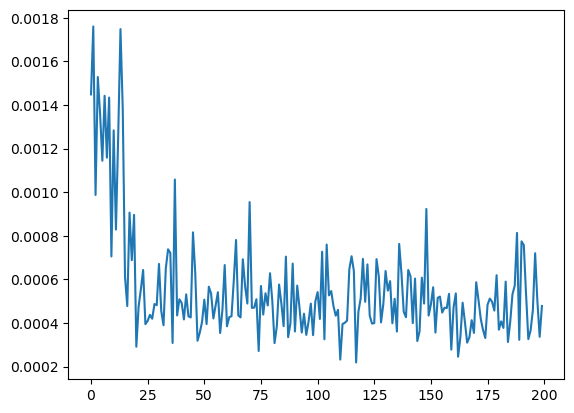

In [176]:
num_epochs = 200
losses = []

for epoch in range(num_epochs):
    for id_batch, (x_batch, y_batch) in enumerate(dataloader):
        # print(y_batch)
        outputs = model(x_batch)
        # print(outputs)
        y_batch = y_batch.reshape(outputs.shape)
        
        optimizer.zero_grad()
        # Attempt to penalize hard for negative value outputs
        loss = criteria(outputs, y_batch) + torch.any(outputs < 0).long().cpu()
        loss.backward()
        optimizer.step()
        
    lr_scheduler.step()
        
    print("Epoch: {}/{}, Loss: {:.8f}".format(epoch+1, num_epochs, loss.item()))
    losses.append(loss.item())

import matplotlib.pyplot as plt

plt.plot(range(0, num_epochs), losses)

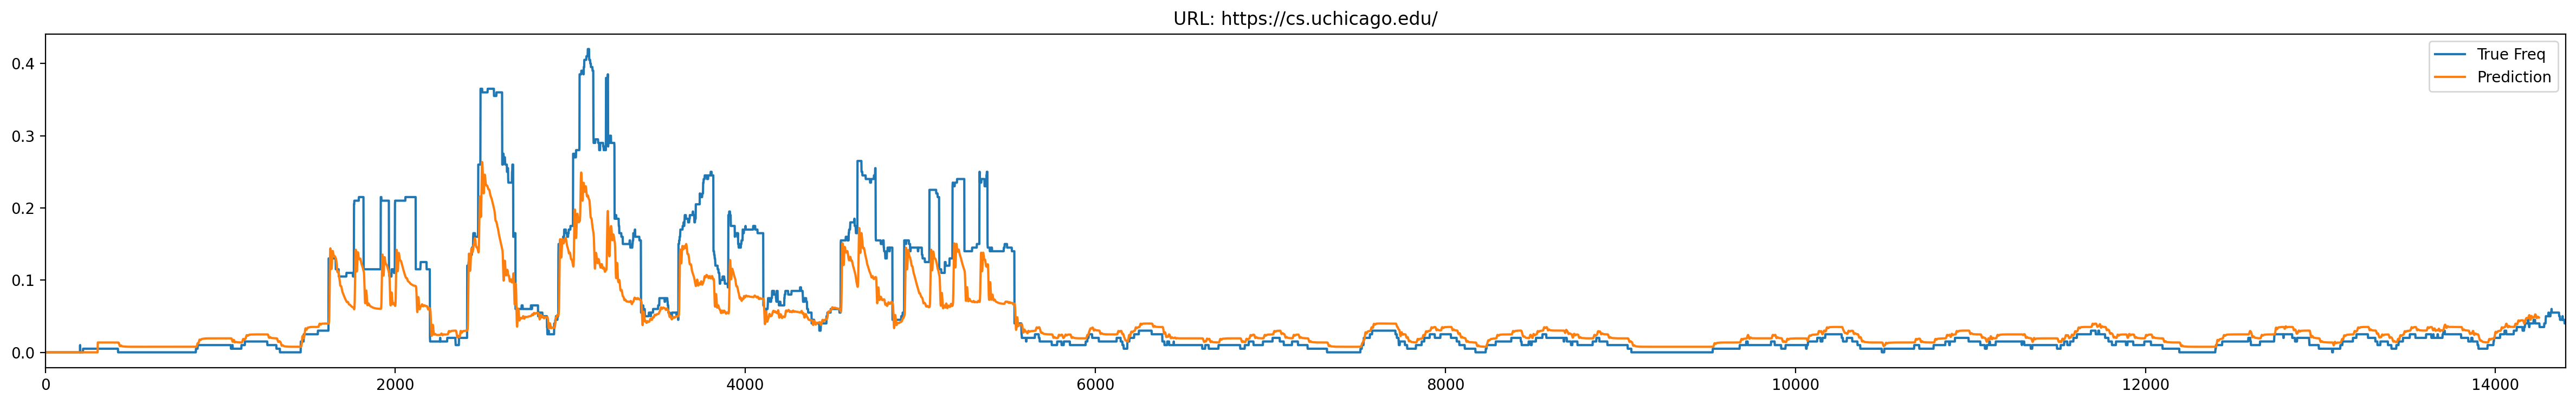

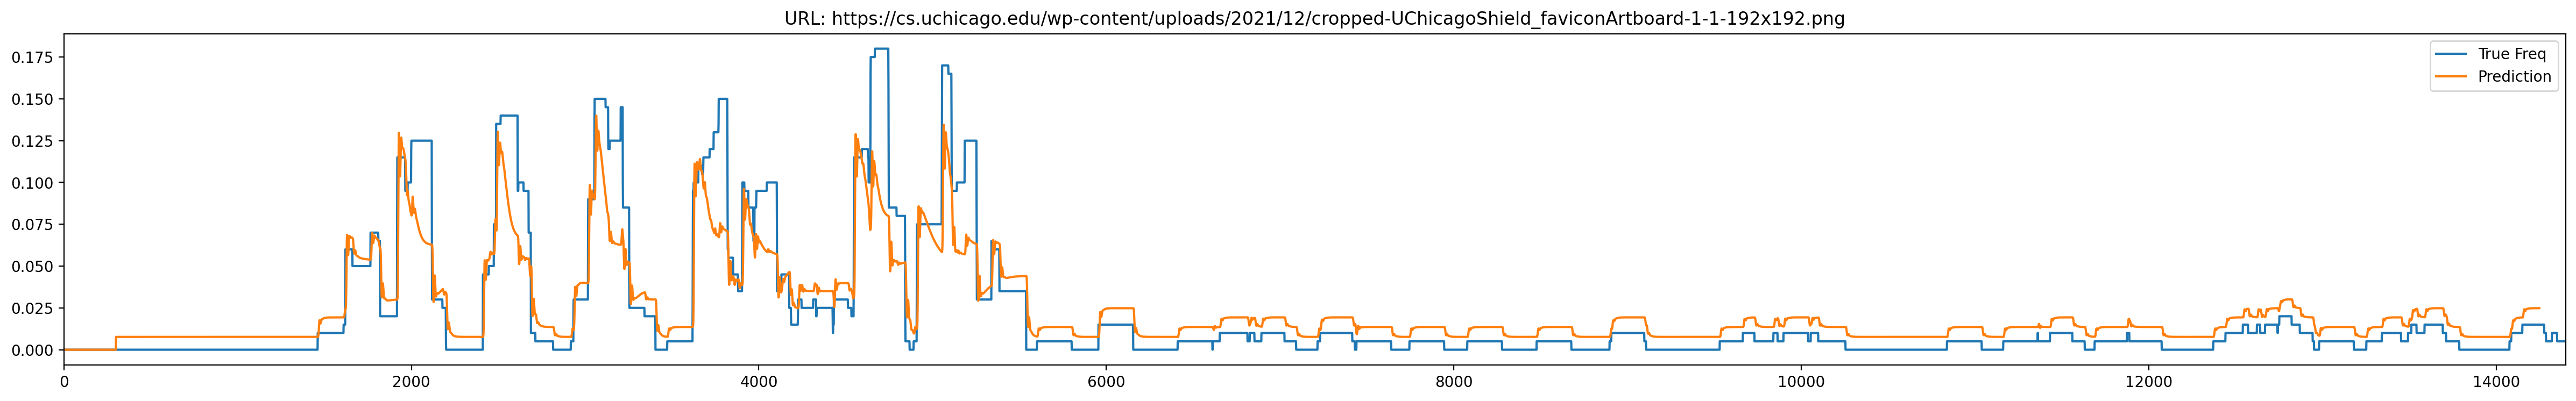

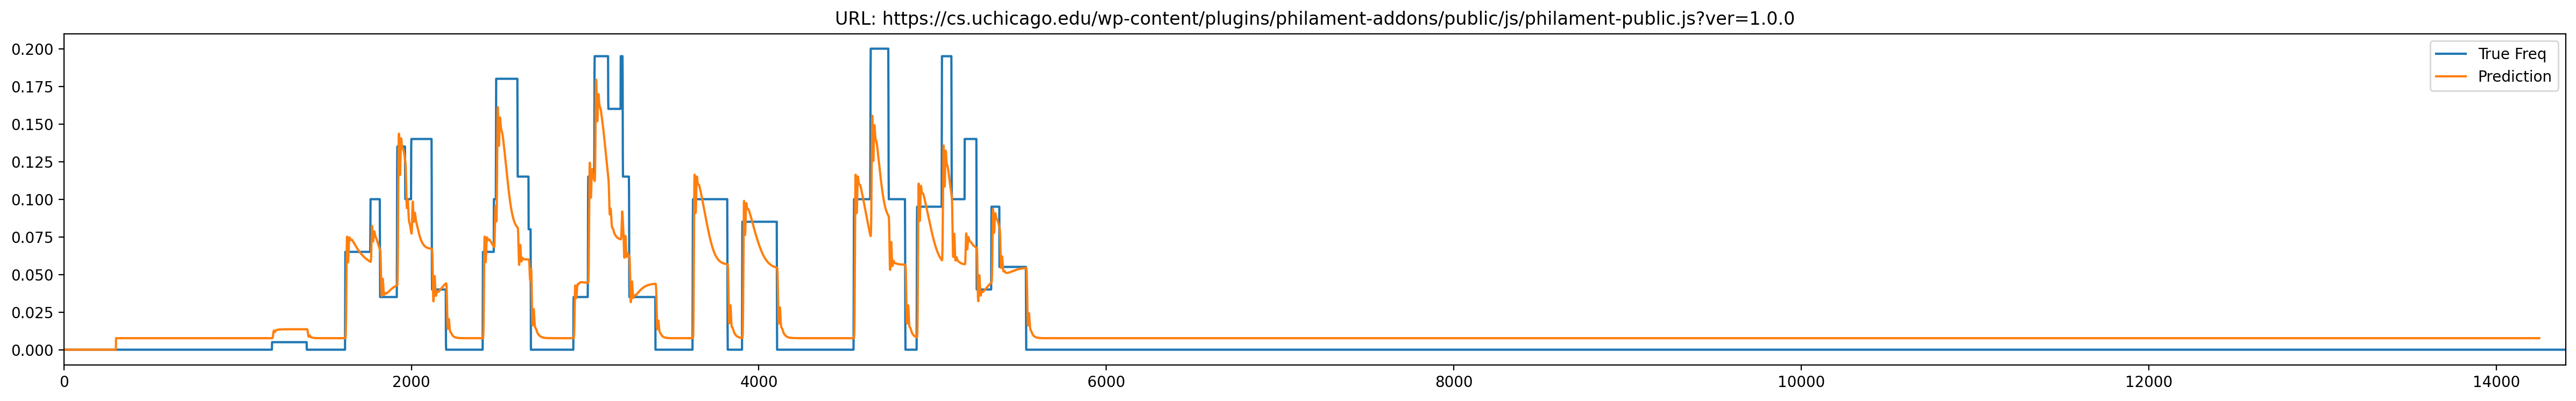

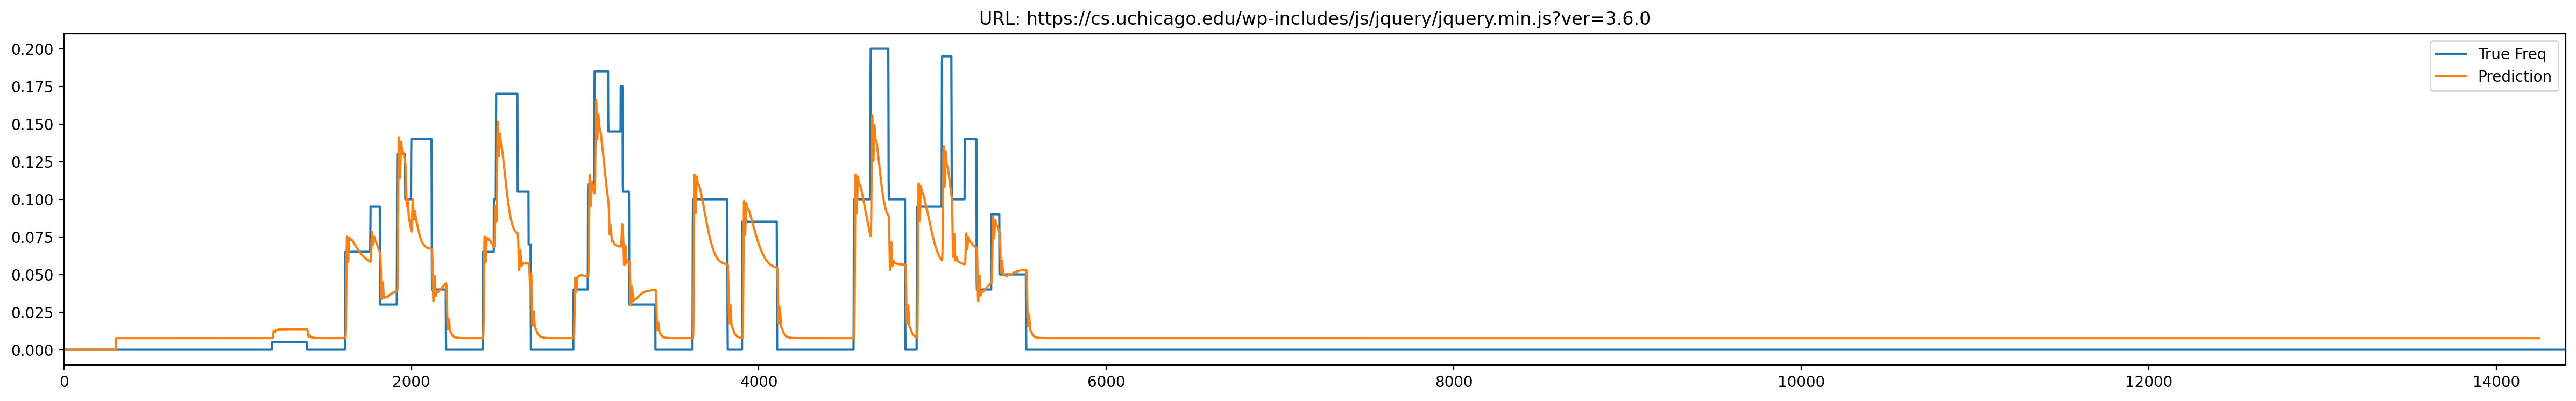

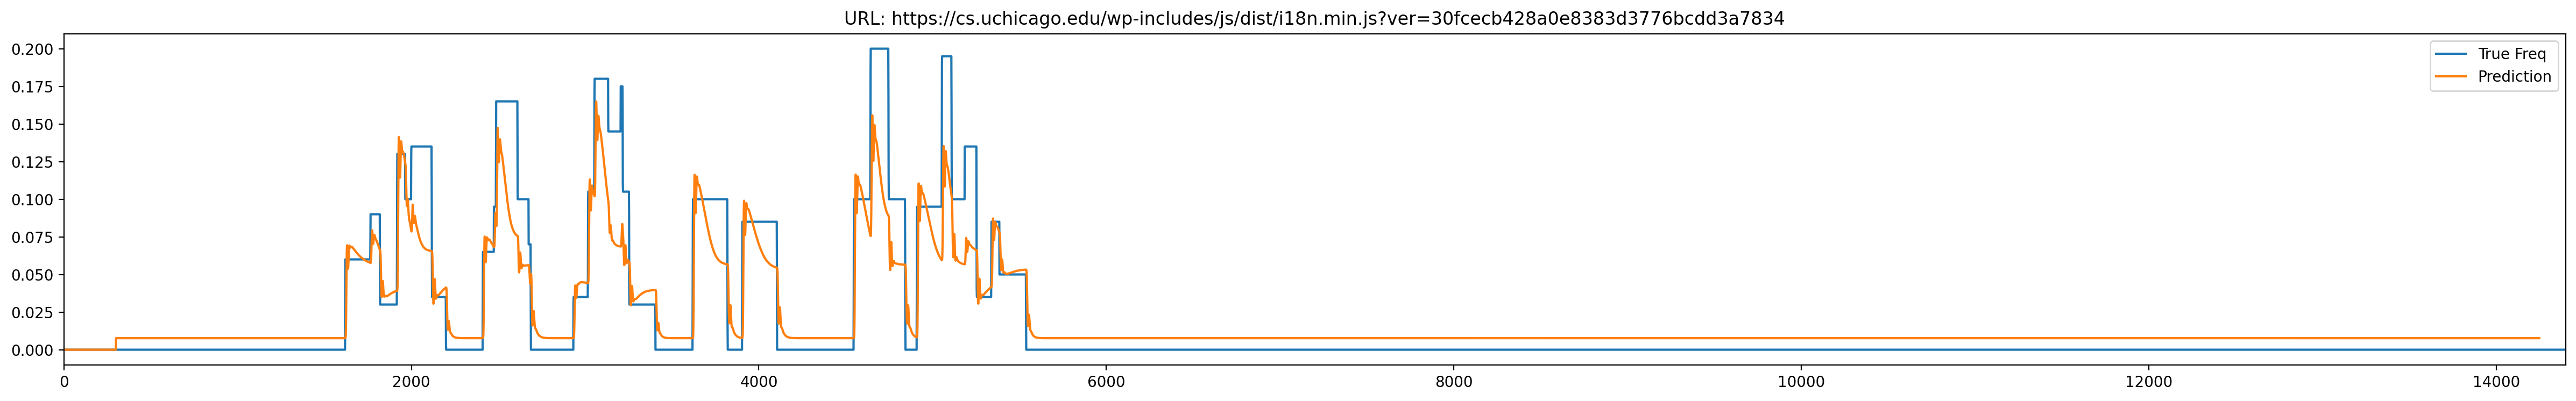

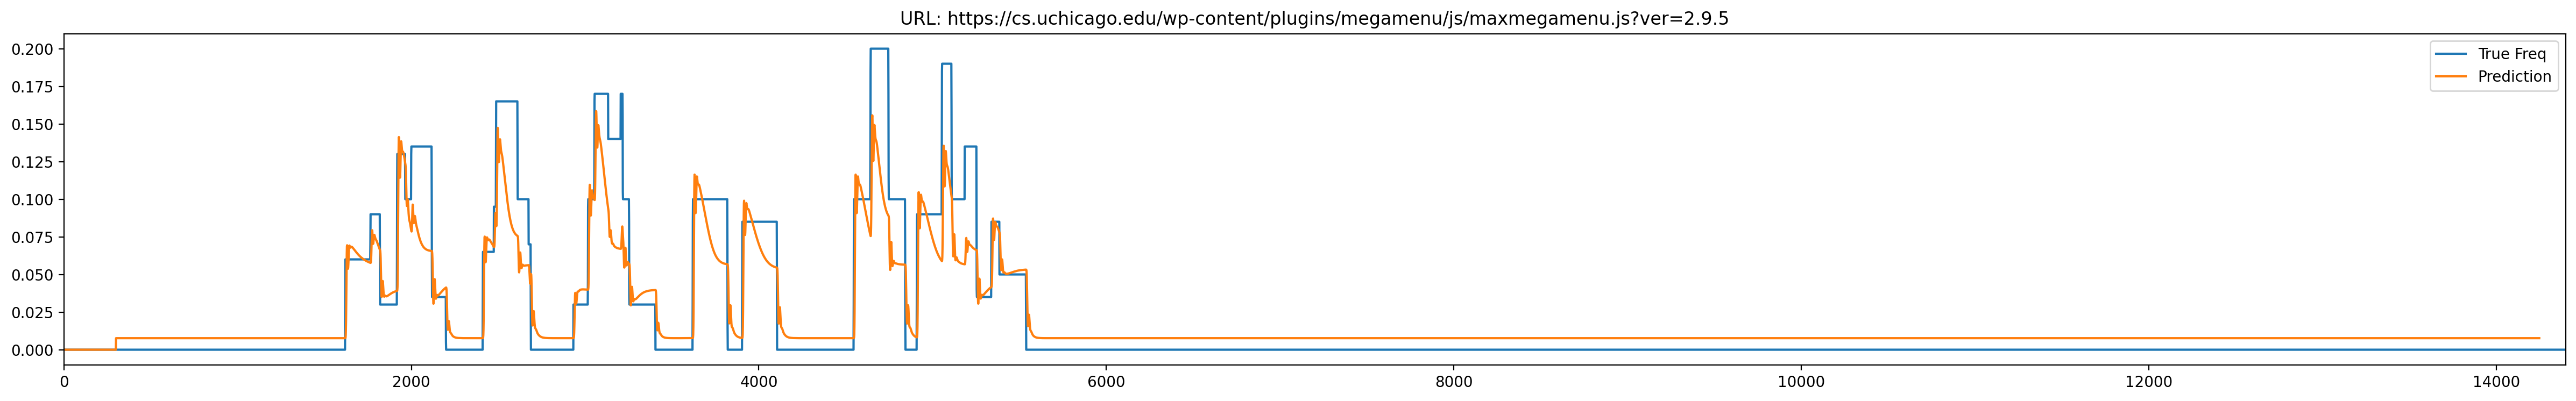

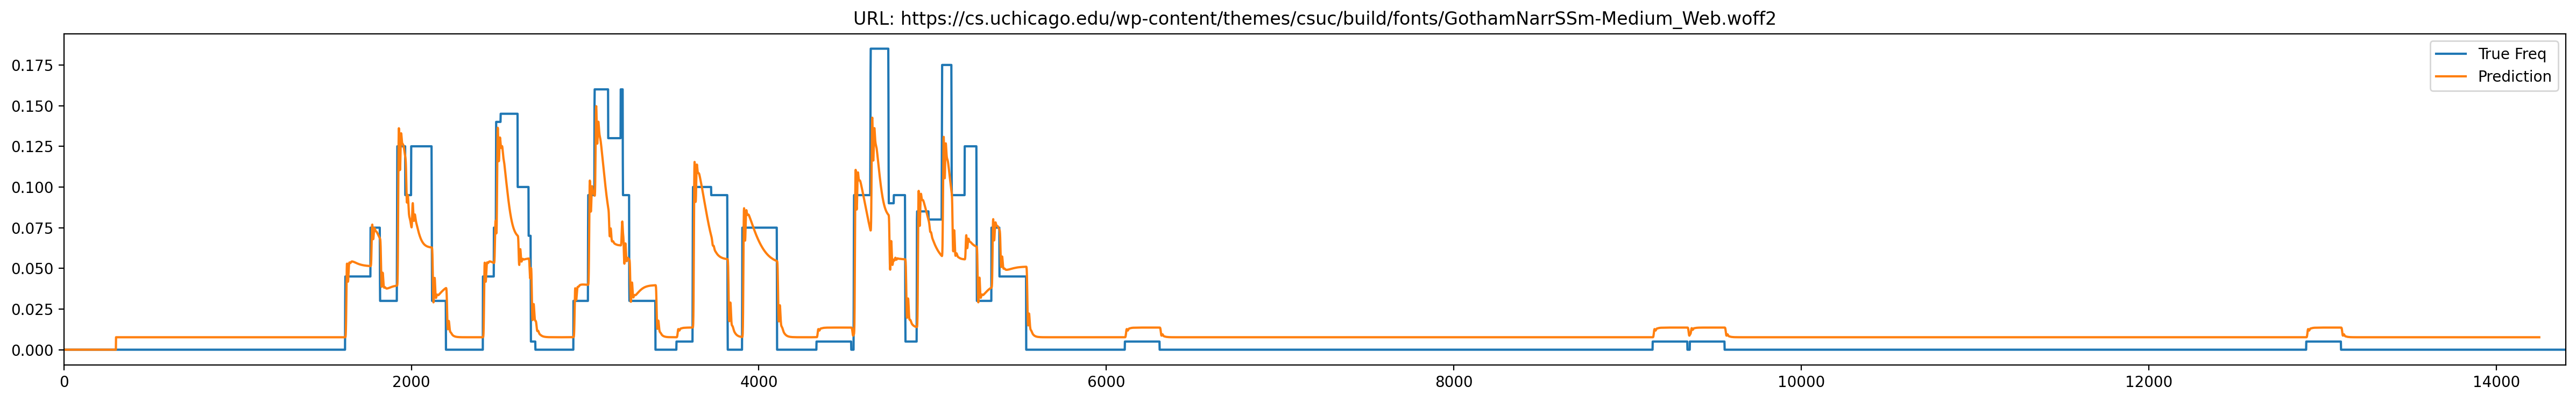

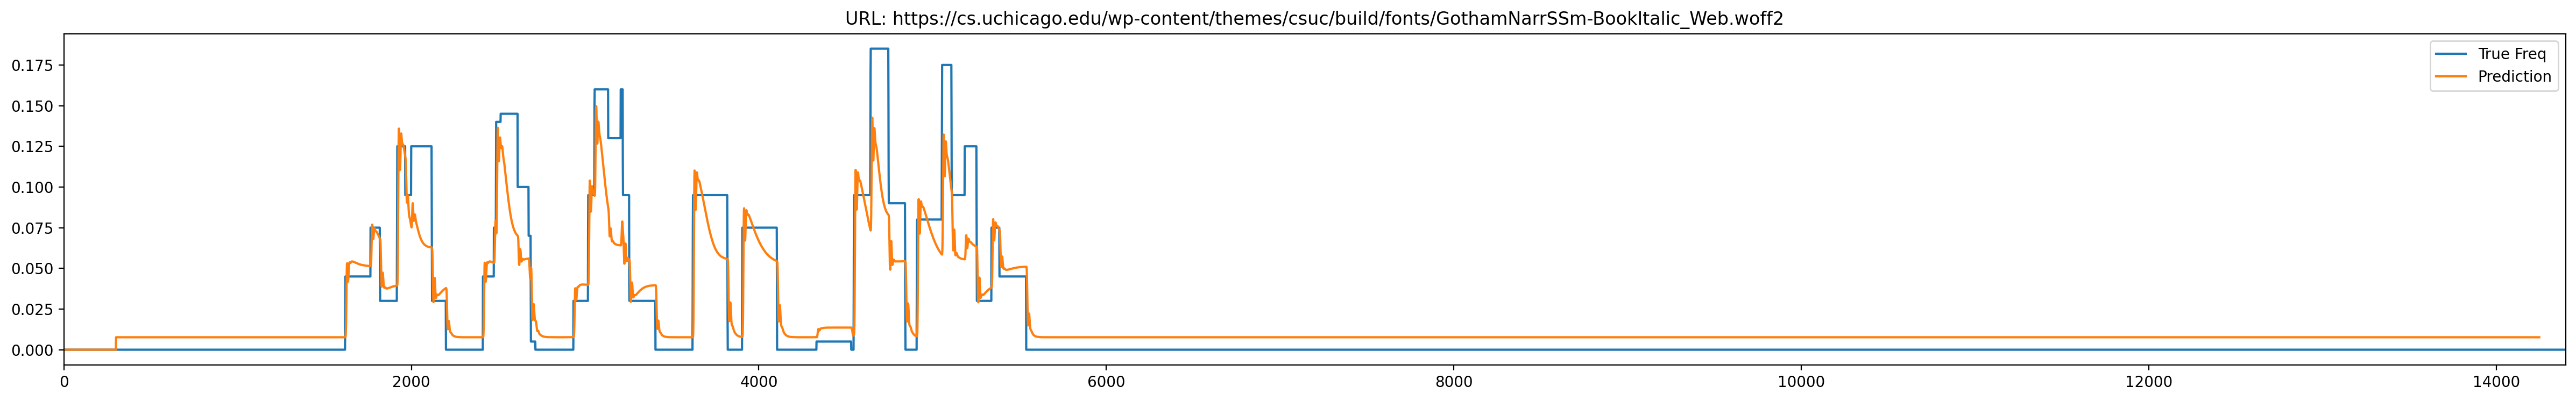

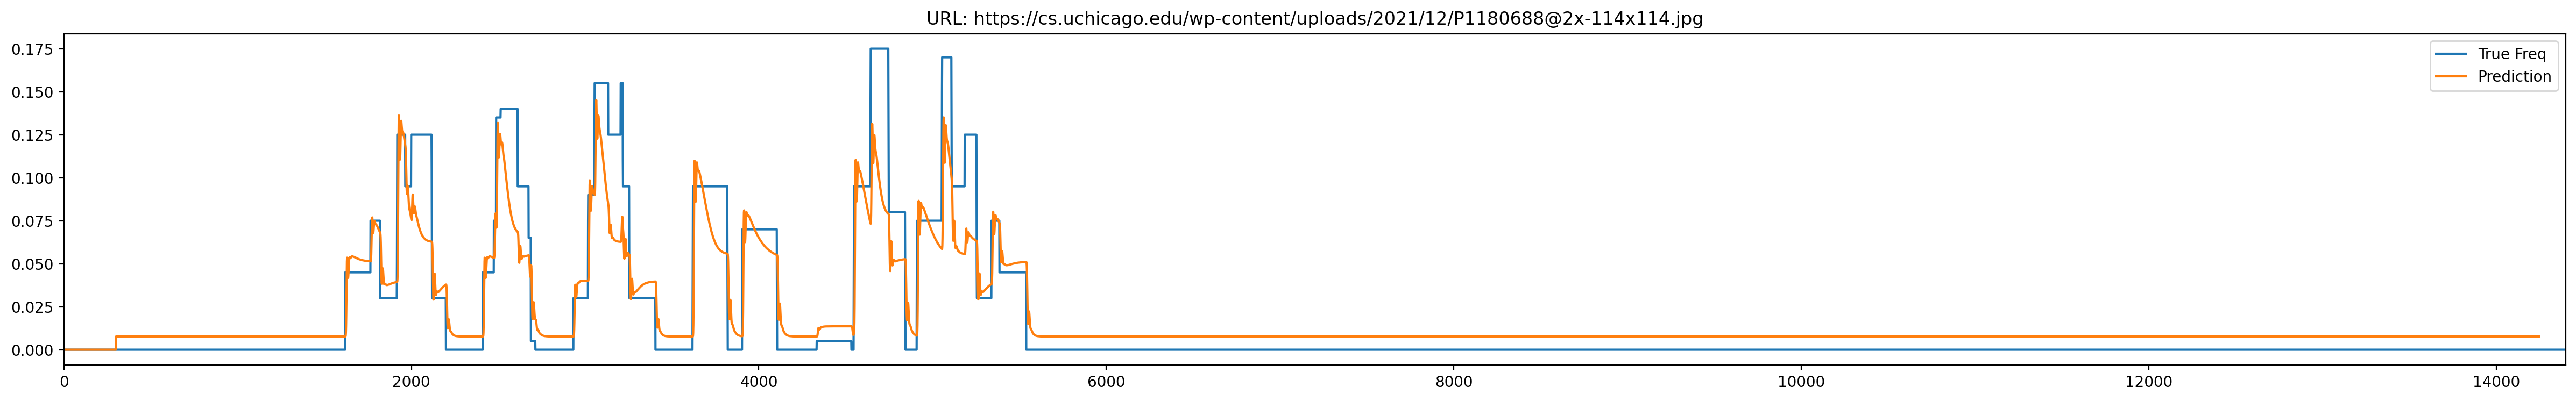

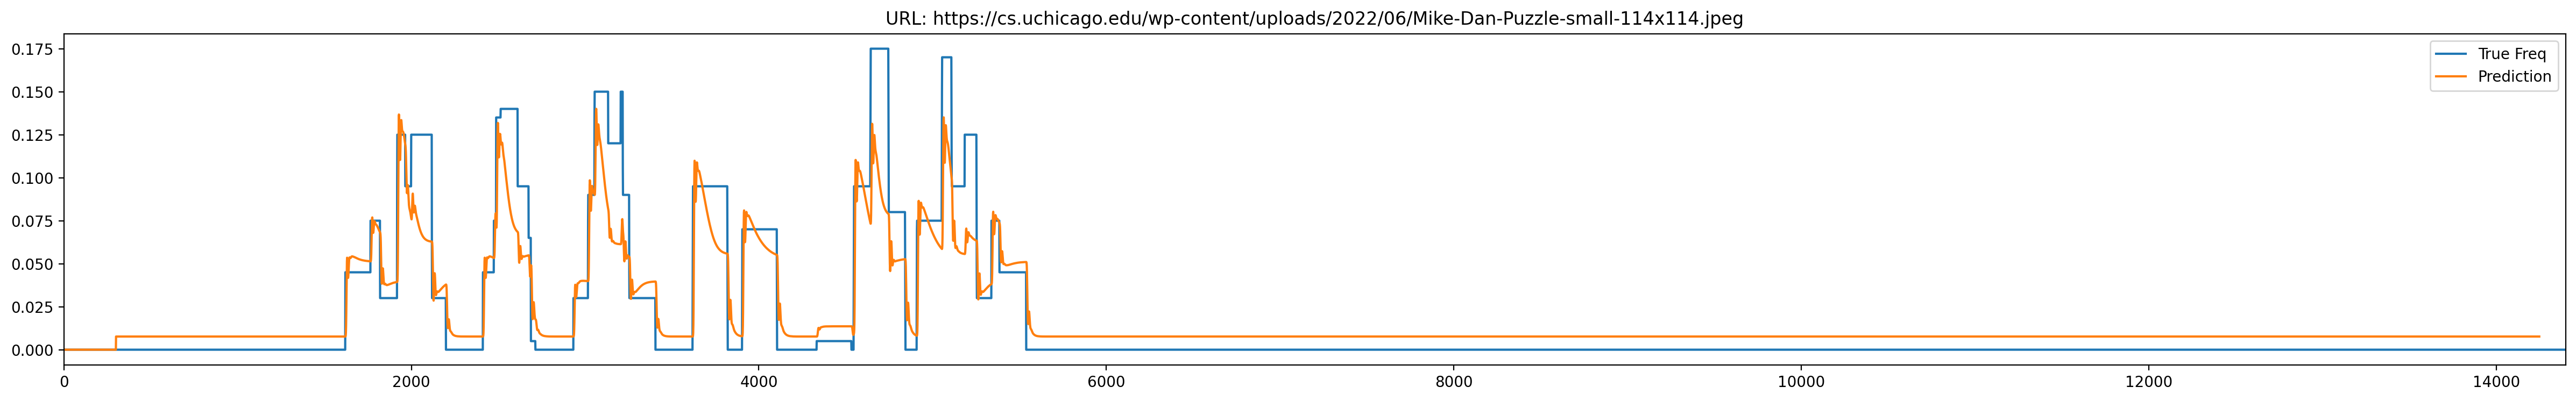

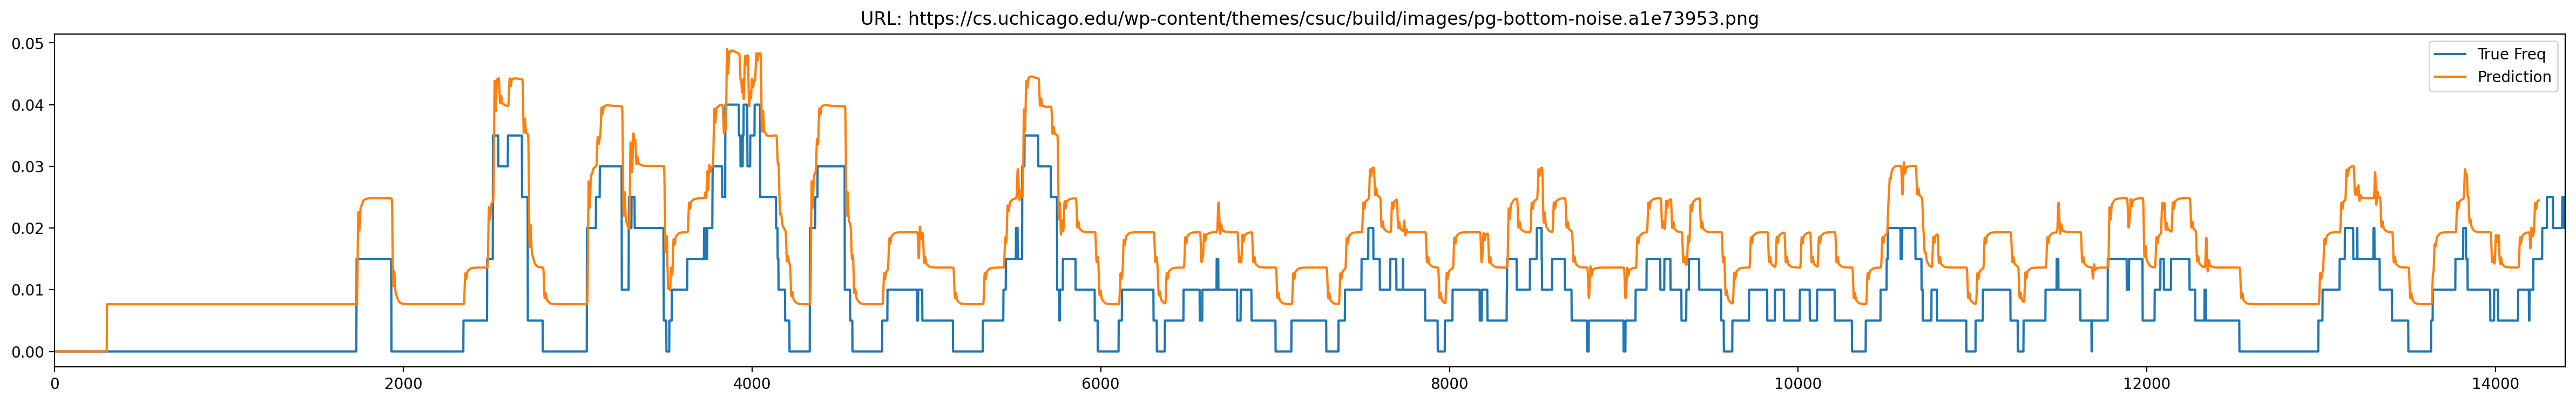

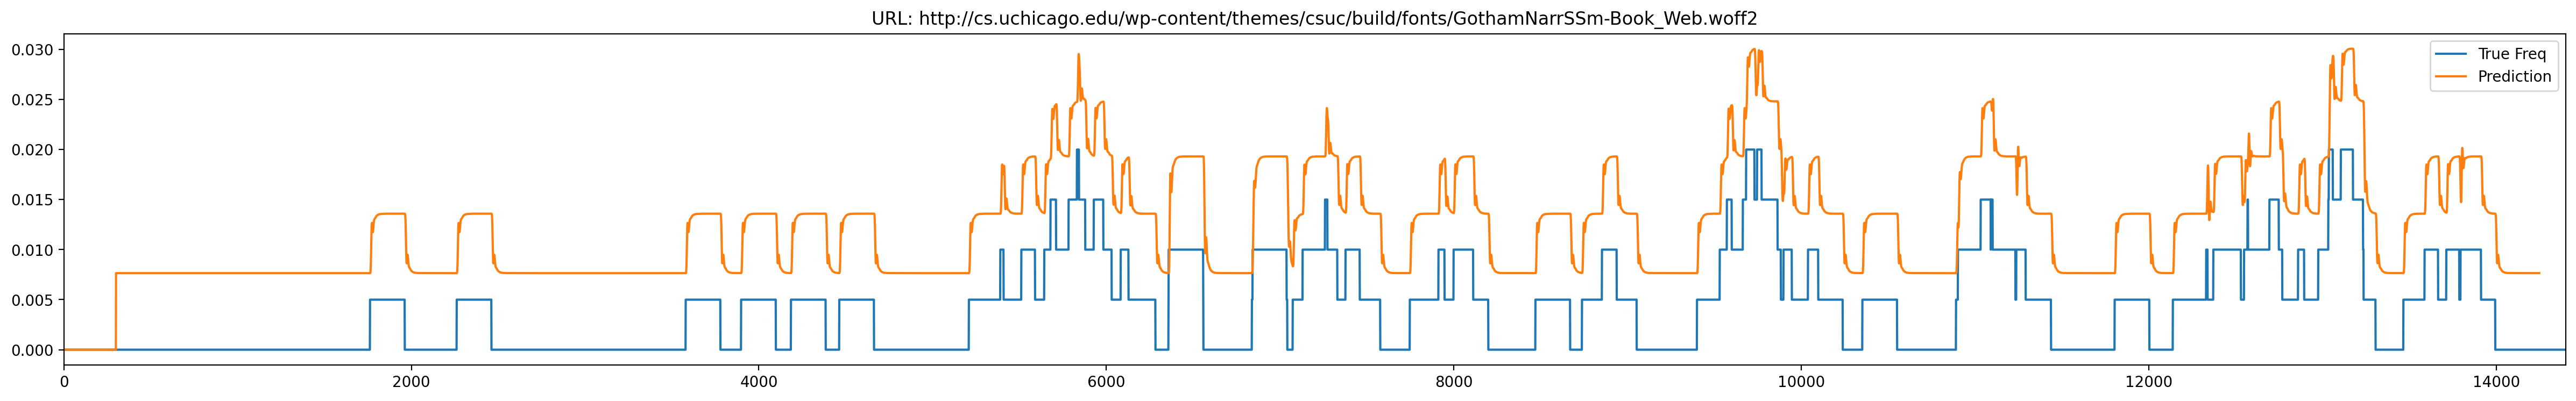

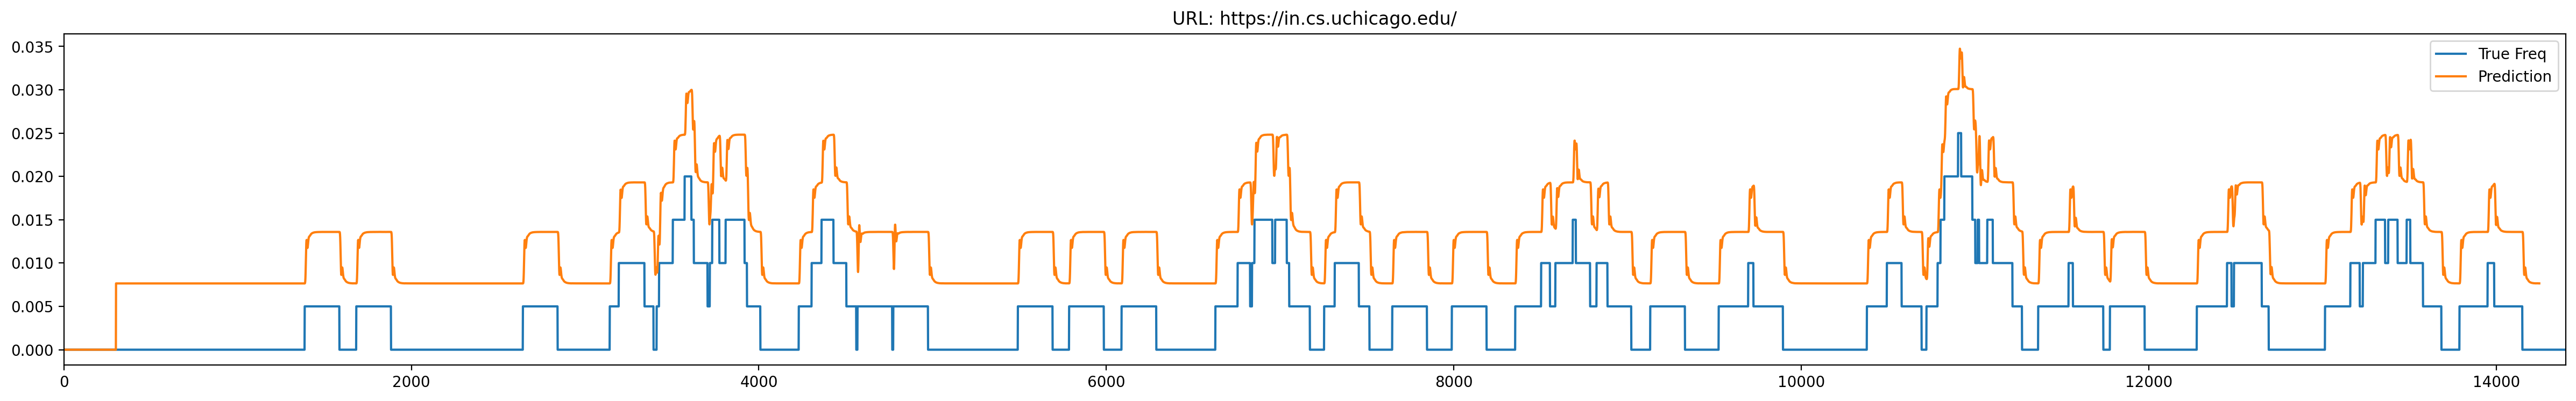

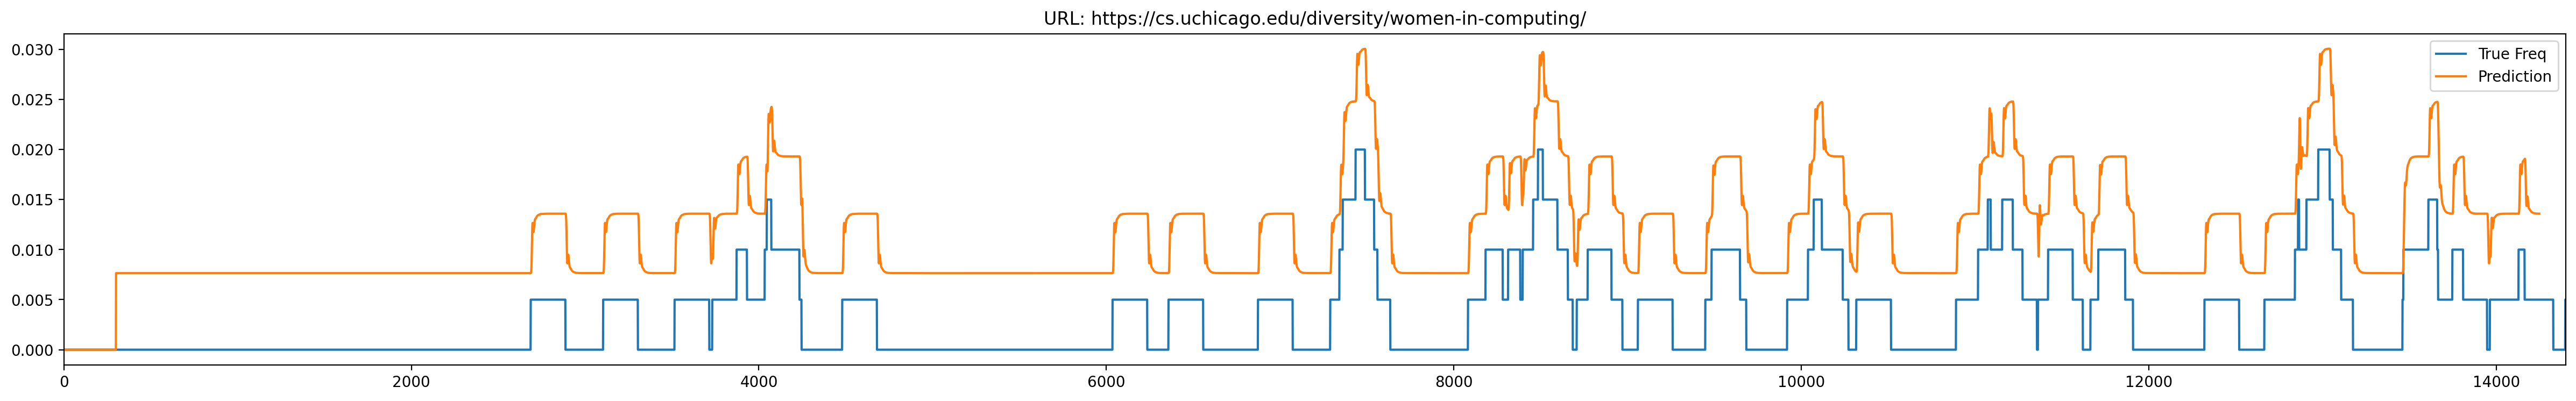

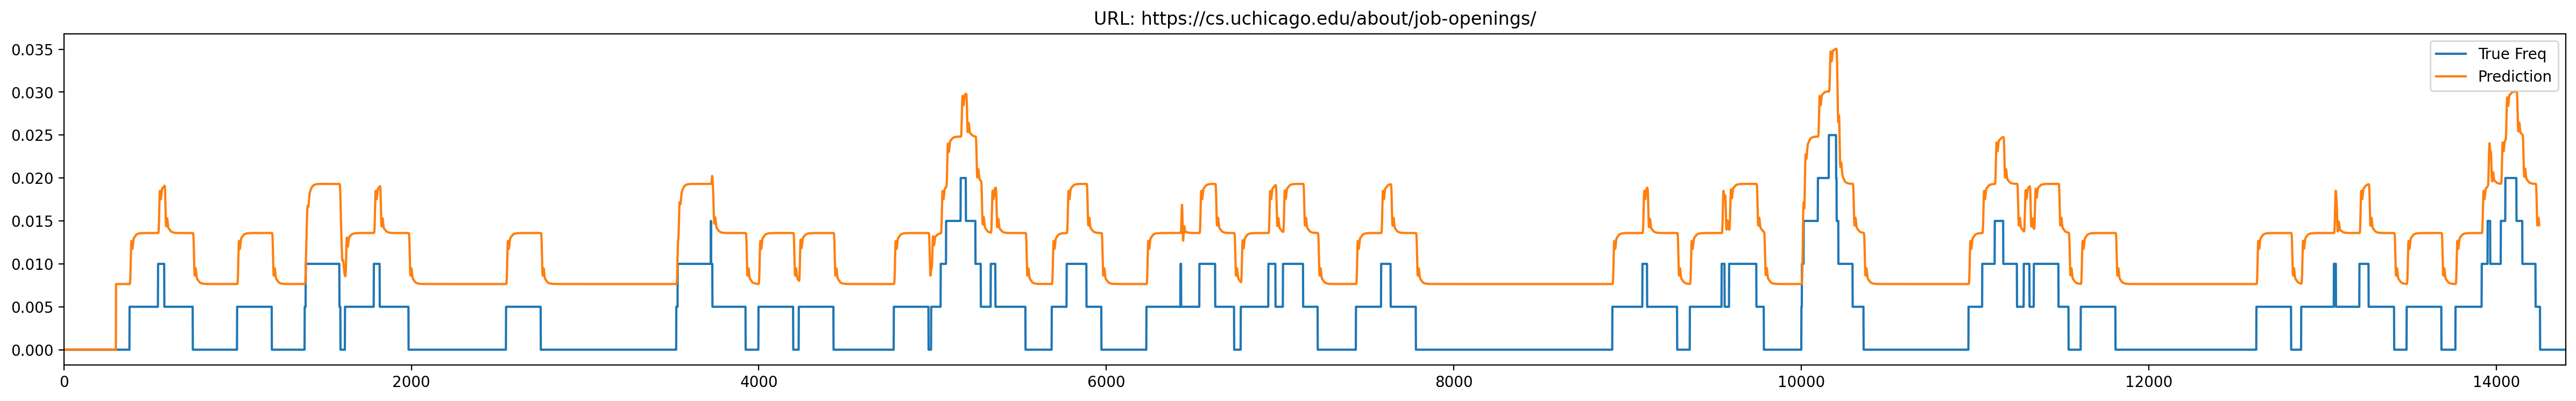

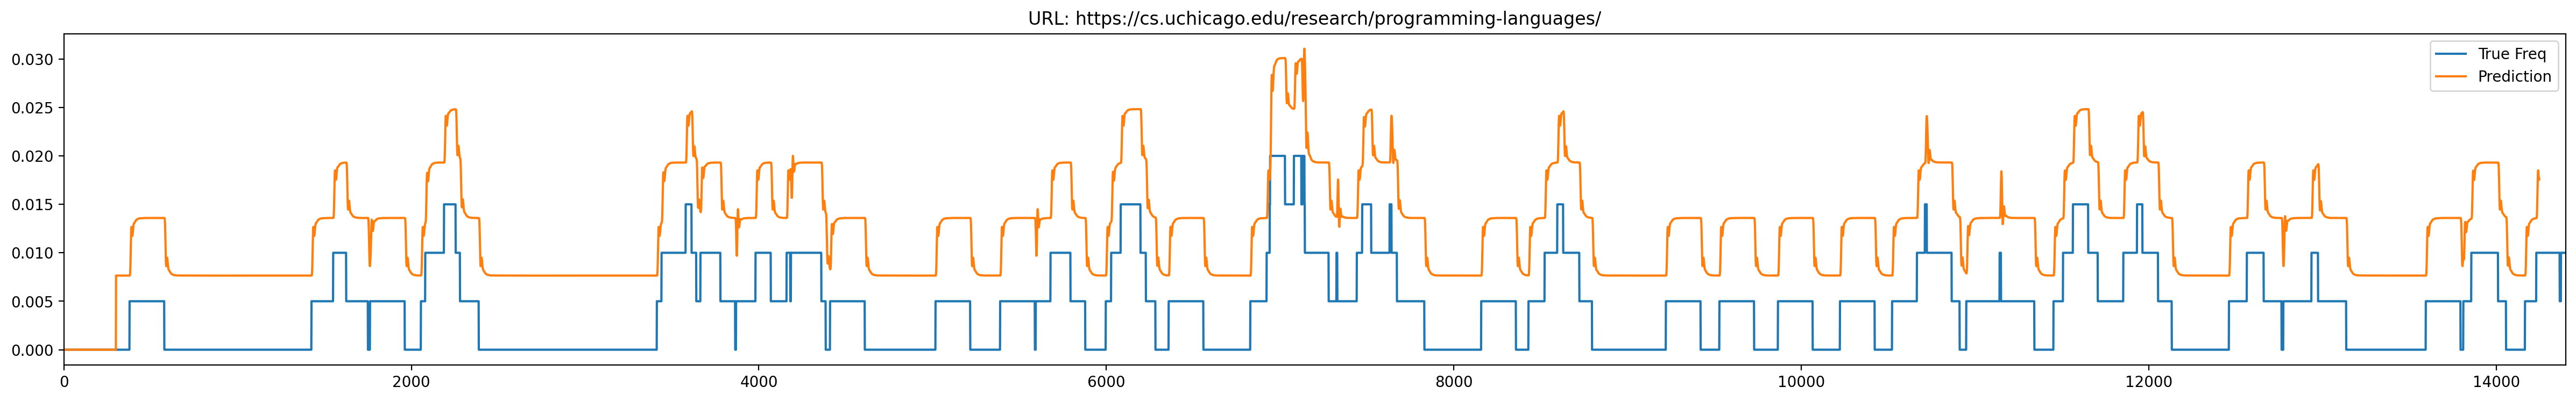

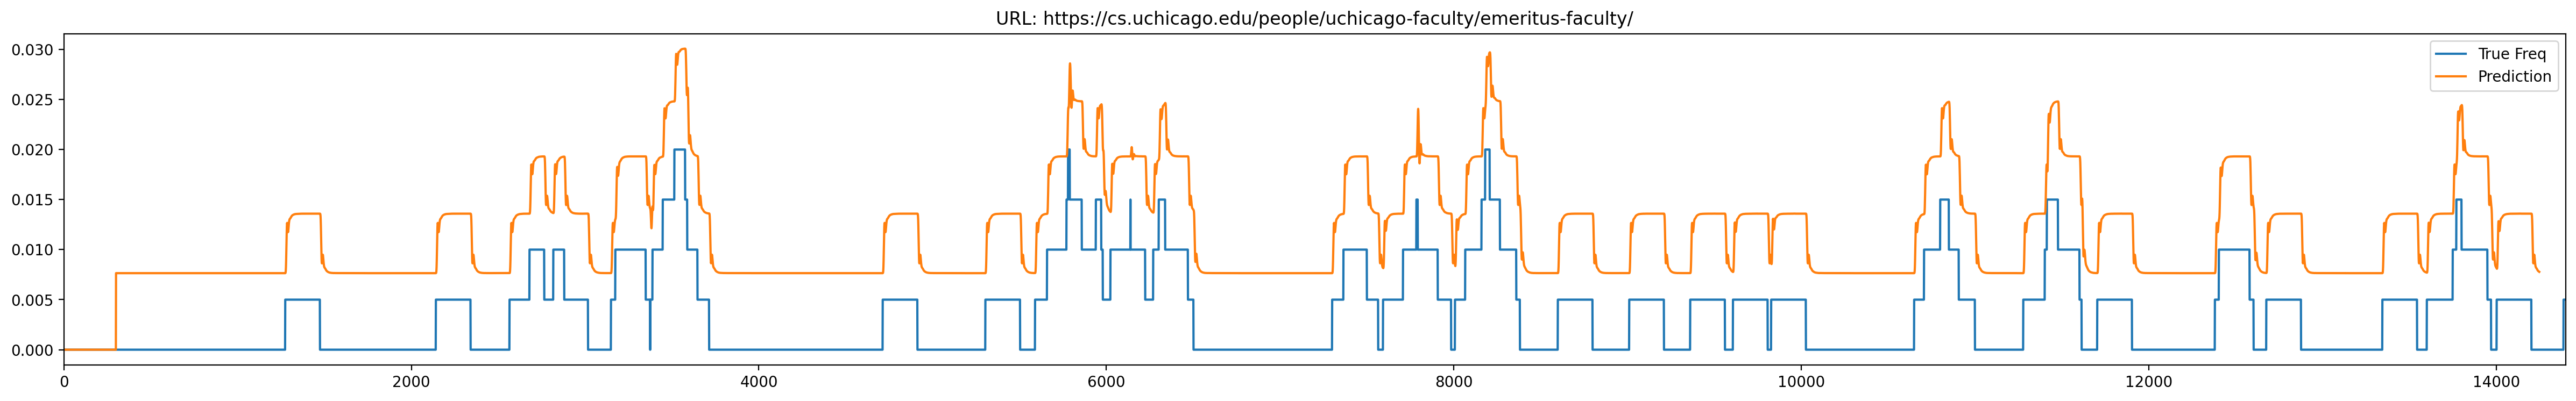

In [177]:
def infer_plot_pred(test_pdf, url):
    test_X, _ = gen_train(test_pdf, window_size, output_size)

    dataset_test = TensorDataset(test_X)
    dataloader_test = DataLoader(dataset_test, batch_size=64)

    model.eval()
    y_test_preds = []
    for id_batch, (x_batch) in enumerate(dataloader_test):
        y_pred = model(x_batch[0])
        y_pred = y_pred.cpu().detach().numpy()
        
        for batch_pred in y_pred:
            # print(batch_pred.shape)
            y_test_preds.append(batch_pred[-1])
    
    model.train()
    plt.figure(figsize=(30, 4), dpi=200)
    plt.plot(test_pdf['count_rolling'], label="True Freq")
    plt.plot([0]*window_size + [0]*xclip[0] + y_test_preds, label="Prediction")
    plt.xlim(xclip)
    # plt.ylim((0, 0.25))
    plt.title("URL: {}".format(url))
    plt.legend(loc='upper right')

for i in range(len(frequency_pdfs)):
    infer_plot_pred(frequency_pdfs[i], plot_urls[i])

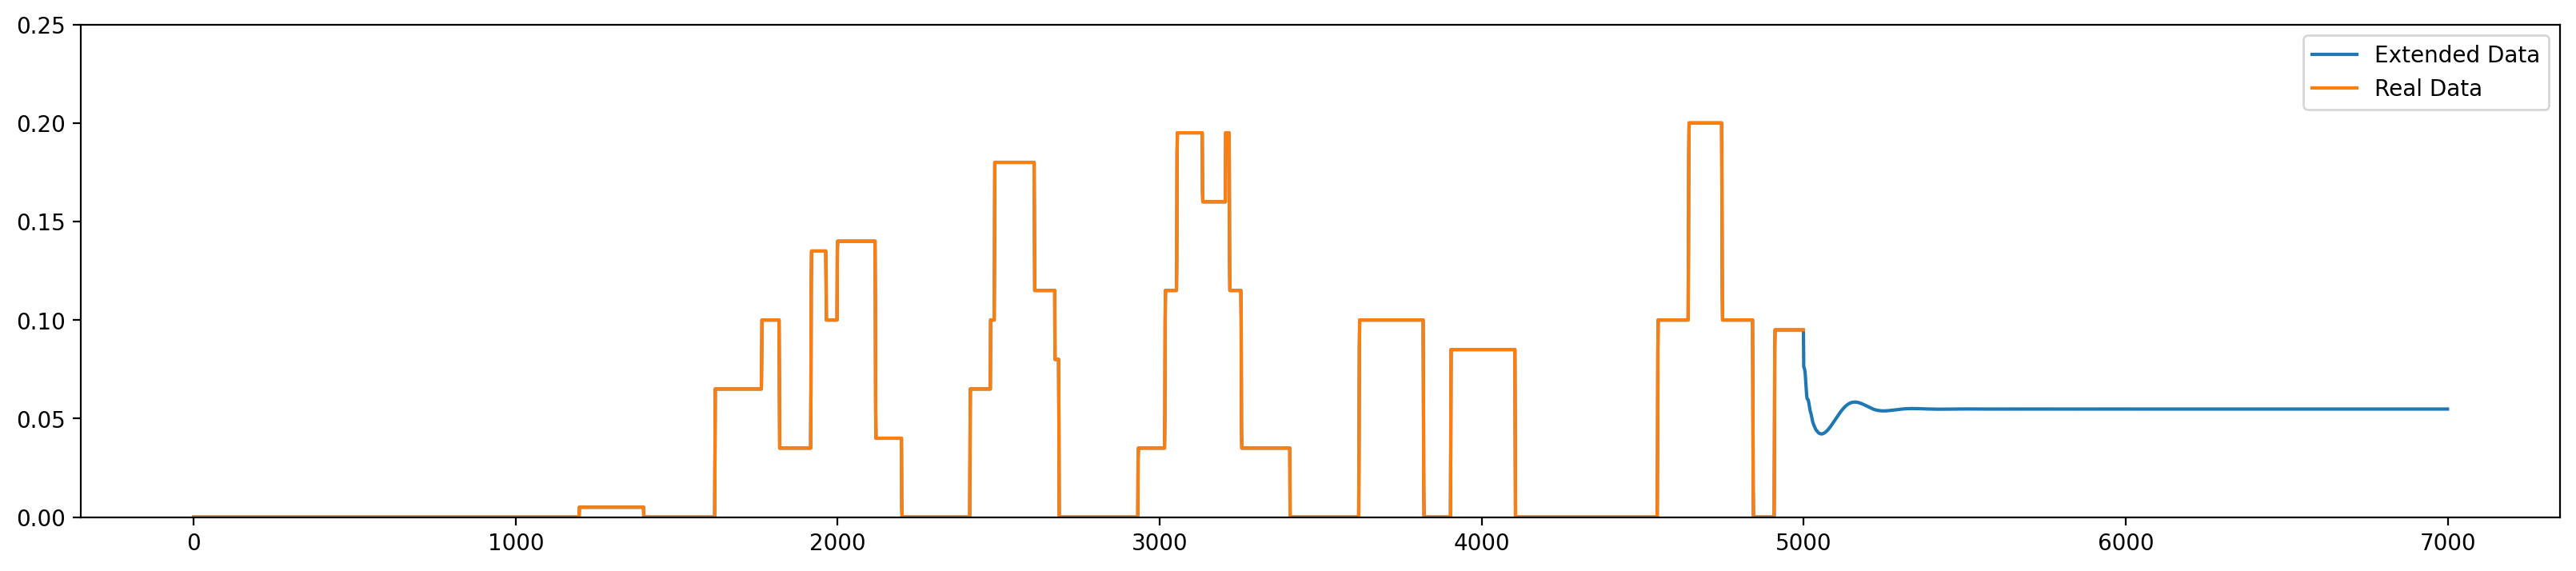

In [178]:
import copy

real_data = frequency_pdfs[2]['count_rolling'].to_numpy()[xclip[0]:5000]

extend_count = 2000  
extended_data = list(copy.deepcopy(real_data))

model.eval()

for i in range(extend_count):
    x_input = extended_data[-1-window_size:-1]
    x_input = torch.Tensor(x_input).to(device).reshape((1, window_size, 1))
    
    y_pred = model(x_input)
    y_pred = y_pred.cpu().detach().numpy()
    
            
    extended_data.append(y_pred.flatten().tolist()[-1])

model.train()    
plt.figure(figsize=(20, 4), dpi=200)

plt.plot(extended_data, label='Extended Data')
plt.plot(real_data, label="Real Data")
plt.ylim(0, 0.25)
plt.legend(loc='upper right')